## Imports

In [2]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [1]:
import os
import re
import spacy
import numpy as np
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import KeyedVectors, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

## Data loading

In [2]:
filename = "boardgames.csv"
df = pd.read_csv(filename, sep=";")
df.head()

,id,name,description,year,rating,complexity
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58934,4.3081
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.65971,1.9643
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47612,2.4423
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35072,2.4923


## Task 1: Text Preprocessing and vectorization

### Text Preprocessing

In [3]:
# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

# We implement data cleaning using spaCy
def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Apply spaCy NLP processing
    doc = nlp(text)

    # Remove stopwords, lemmatize words, and exclude punctuations
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    return " ".join(tokens)

In [4]:
# Apply the cleaning function to all descriptions
df["clean_description"] = df["description"].apply(clean_text)

In [5]:
# Example: original and cleaned text for first entry
print("Original:\n", df["description"][0])
print("Cleaned:\n", df["clean_description"][0])

Original:
 Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regional election and has some media influence in the region, then the party will receive some media-control victory points. Third, each party has a national party membership which will grow as the game progresses and this will supply a fair number of victory points. Lastly, parties score some victory points if their party platform matches the national opinions at the end of the game.&#10;&#10;The 1986 edition featured four parties from the old West Germany and

#### Save clean dataset (if desired)

In [6]:
df.to_csv("boardgames_clean.csv", index=False, encoding="utf-8", sep=";")

### Vectorization

#### BoW and TF-IDF

In [7]:
# For this task, we will mainly be working with the column "clean_description".
# We will tokenize this part fist
tokenized_descr = [clean_description.split() for clean_description in df["clean_description"]]

In [8]:
# Then we will create a dictionary and obtain both the BoW corpus and the TF-IDF corpus
# BoW corpus
dictionary = corpora.Dictionary(tokenized_descr)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

# TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Now we would like to obtain some insights from our data using the TF-IDF corpus. However, we cannot use it as it is. `tfidf_corpus`is a sparse corpus matrix, not a dense numpy matrix.

Gensim is optimized for streaming large corpora and if we wanted to do some visualizations, we would need to convert it to dense form.

In [9]:
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)

# Create empty matrix
X_tfidf_gensim = np.zeros((num_docs, num_terms))

# Fill it with TF-IDF scores
for doc_idx, doc in enumerate(tfidf_corpus):
    for term_id, tfidf_score in doc:
        X_tfidf_gensim[doc_idx, term_id] = tfidf_score

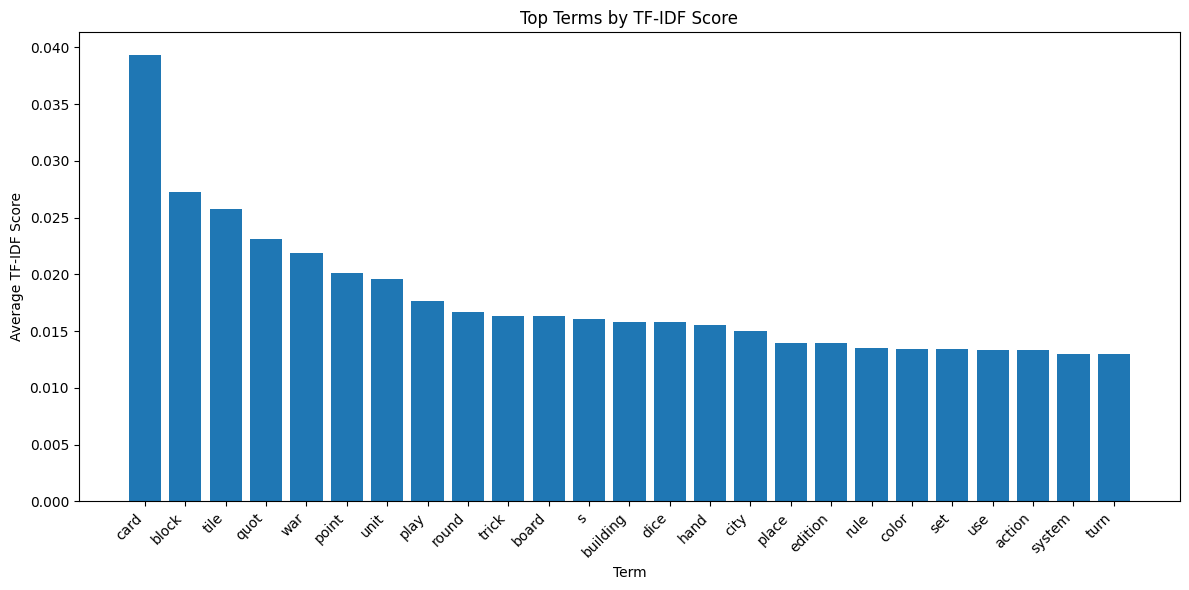

In [10]:
# Compute average TF-IDF per term
avg_tfidf_scores = X_tfidf_gensim.mean(axis=0)

# Top-N terms
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = [dictionary[i] for i in top_term_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=terms)
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

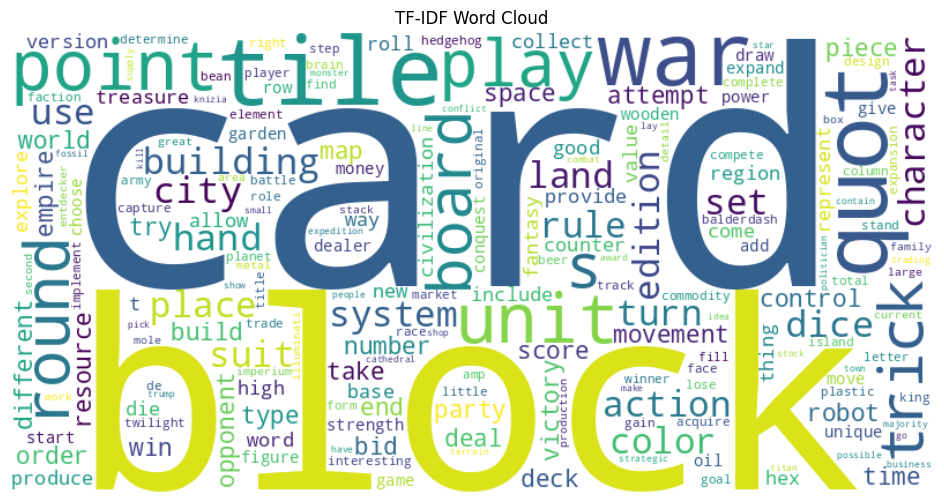

In [11]:
# Total TF-IDF score per term across all documents
tfidf_term_scores = X_tfidf_gensim.sum(axis=0)

# Map term to score
word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(num_terms)}

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud')
plt.show()

#### GloVe and Doc2Vec

In [12]:
# Load pretrained GloVe
w2v_model = gensim.downloader.load("glove-wiki-gigaword-100")

def get_avg_vector(doc):
    words = doc.split()
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack(df["clean_description"].apply(get_avg_vector))

[==================================================] 100.0% 128.1/128.1MB downloaded


In [13]:
# Prepare data
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df["clean_description"])]

# Train
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)

# Vectorize
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

#### LDA

In [14]:
corpus = df['clean_description'].tolist()

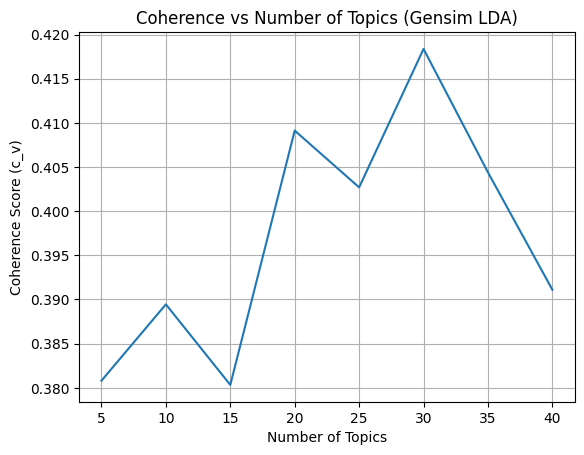

In [15]:
# Try different numbers of topics
coherence_scores = []
models = []
for k in range(5, 41, 5):
    model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)
    models.append(model)

# Plot coherence vs. topic count
import matplotlib.pyplot as plt
plt.plot(range(5, 41, 5), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics (Gensim LDA)")
plt.grid(True)
plt.show()

# Select best model
best_k = range(5, 41, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]

In [16]:
for topic_id, words in best_model.show_topics(num_topics=best_k, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, prob in words]}")


Topic 0: ['card', 'player', 'game', 'quot', 'order', 'robot', 's', 'hand', 'trick', 'resource']
Topic 1: ['temple', 'treasure', 'tikal', 'player', 'game', 'jungle', 'lose', 'score', 'attempt', 'point']
Topic 2: ['player', 'game', 'card', 'edition', 'twilight', 'tile', 'imperium', 'round', 'building', 'rule']
Topic 3: ['player', 'game', 'tower', 'fossil', 'pick', 'reward', 'computer', 'chocolate', 'take', 'win']
Topic 4: ['entdecker', 'player', 'island', 'land', 'game', 'new', 's', 'explore', 'board', 'place']
Topic 5: ['card', 'player', 'play', 'game', 'point', 'expedition', 'oil', 'color', 'total', 'trick']
Topic 6: ['game', 'empire', 'player', 'federation', 'operation', 'expansion', 'quot', 'rule', 'version', 'battle']
Topic 7: ['game', 'party', 'player', 'victory', 'card', 'point', 'arena', 'creature', 's', 'play']
Topic 8: ['game', 'block', 'war', 'unit', 'provide', 'use', 'system', 'strength', 'allow', 'quot']
Topic 9: ['card', 'player', 'bid', 'game', 'deck', 'hand', 'illuminati'

In [26]:
beta_matrix = np.array(best_model.get_topics())
print("Beta shape:", beta_matrix.shape)

Beta shape: (30, 2608)


In [23]:
words = [dictionary[i] for i in range(len(dictionary))]

# We create a dataframe to read the results better
beta_df = pd.DataFrame(beta_matrix, columns=words, index=[f"Topic {i}" for i in range(best_k)])

# Here we display the top words per topic (beta vectors), with the probabilities.
for topic_id in range(best_k):
    print(f"\nTopic {topic_id}:")
    print(beta_df.iloc[topic_id].sort_values(ascending=False).head(10))



Topic 0:
card        0.044942
player      0.041389
game        0.017614
quot        0.016487
order       0.016341
robot       0.015461
s           0.015094
hand        0.014543
trick       0.010133
resource    0.010021
Name: Topic 0, dtype: float32

Topic 1:
temple      0.031727
treasure    0.023865
tikal       0.023865
player      0.016012
game        0.016006
jungle      0.015997
lose        0.015996
score       0.008135
attempt     0.008133
point       0.008133
Name: Topic 1, dtype: float32

Topic 2:
player      0.042692
game        0.036076
card        0.017859
edition     0.016632
twilight    0.012805
tile        0.012791
imperium    0.011528
round       0.010258
building    0.010249
rule        0.009015
Name: Topic 2, dtype: float32

Topic 3:
player       0.027646
game         0.018812
tower        0.016831
fossil       0.013494
pick         0.010148
reward       0.010147
computer     0.010141
chocolate    0.010123
take         0.008660
win          0.008406
Name: Topic 3, dtype

In [29]:
best_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

# igual usar esto que es más compacto


[(0,
  '0.045*"card" + 0.041*"player" + 0.018*"game" + 0.016*"quot" + 0.016*"order" + 0.015*"robot" + 0.015*"s" + 0.015*"hand" + 0.010*"trick" + 0.010*"resource"'),
 (1,
  '0.032*"temple" + 0.024*"treasure" + 0.024*"tikal" + 0.016*"player" + 0.016*"game" + 0.016*"jungle" + 0.016*"lose" + 0.008*"score" + 0.008*"attempt" + 0.008*"point"'),
 (2,
  '0.043*"player" + 0.036*"game" + 0.018*"card" + 0.017*"edition" + 0.013*"twilight" + 0.013*"tile" + 0.012*"imperium" + 0.010*"round" + 0.010*"building" + 0.009*"rule"'),
 (3,
  '0.028*"player" + 0.019*"game" + 0.017*"tower" + 0.013*"fossil" + 0.010*"pick" + 0.010*"reward" + 0.010*"computer" + 0.010*"chocolate" + 0.009*"take" + 0.008*"win"'),
 (4,
  '0.028*"entdecker" + 0.022*"player" + 0.020*"island" + 0.019*"land" + 0.018*"game" + 0.016*"new" + 0.013*"s" + 0.013*"explore" + 0.012*"board" + 0.010*"place"'),
 (5,
  '0.082*"card" + 0.039*"player" + 0.036*"play" + 0.029*"game" + 0.025*"point" + 0.024*"expedition" + 0.020*"oil" + 0.020*"color" + 0.0

In [35]:
theta_matrix = []
for doc in bow_corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    theta_matrix.append([prob for _, prob in doc_topics])

theta_matrix = np.array(theta_matrix)
print("Theta shape:", theta_matrix.shape)


Theta shape: (122, 30)


In [38]:
# Dataframe for the thetas
theta_df = pd.DataFrame(theta_matrix, columns=[f"Topic {i}" for i in range(best_k)])

# We just display the most relevant topic (the one with the highest probability)
theta_df["Dominant Topic"] = theta_df.idxmax(axis=1)

print(theta_df[["Dominant Topic"]])


    Dominant Topic
0          Topic 7
1          Topic 0
2         Topic 11
3         Topic 11
4         Topic 17
..             ...
117       Topic 18
118        Topic 9
119       Topic 22
120        Topic 9
121        Topic 4

[122 rows x 1 columns]


In [22]:
#pip install pyLDAvis

In [21]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, bow_corpus, dictionary)
vis


/usr/local/lib/python3.11/dist-packages/pyLDAvis/_prepare.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_table['Freq'] = token_table['Freq'].round()
/usr/local/lib/python3.11/dist-packages/pyLDAvis/_prepare.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_table['Term'] = vocab[token_table.index.values].values


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.145250  0.088273       1        1  8.679157
27    -0.067417 -0.264167       2        1  7.757433
13    -0.159538  0.058747       3        1  7.368426
24    -0.127022  0.045119       4        1  6.650847
6     -0.013516 -0.114580       5        1  5.902465
2     -0.109576 -0.029713       6        1  5.896313
5     -0.163631  0.094136       7        1  5.451077
12    -0.091441  0.064902       8        1  4.849625
17    -0.025818 -0.044343       9        1  4.743873
21    -0.061987 -0.008088      10        1  4.613973
11    -0.002197 -0.034780      11        1  3.932972
8     -0.031250 -0.254051      12        1  3.909763
16    -0.091368  0.021585      13        1  3.782000
18    -0.089616  0.012398      14        1  3.456012
9     -0.084795  0.083457      15        1  3.329090
7     -0.017383 -0.012447      16        1  2.926693
4      0.045855  0.032190      17        1  2.652004
15     0.068166 -0.041921      18        1  2.573514
14     0.011003  0.040018      19        1  1.786387
3      0.038289  0.056949      20        1  1.770547
26     0.057222  0.013794      21        1  1.553501
22     0.156183  0.040968      22        1  1.402392
10     0.090340 -0.031814      23        1  1.298695
25     0.106359  0.023612      24        1  0.833667
29     0.095427  0.038225      25        1  0.661826
23     0.109617  0.018259      26        1  0.627019
20     0.089253  0.021031      27        1  0.601684
1      0.134045  0.032678      28        1  0.369749
19     0.137410  0.020920      29        1  0.361161
28     0.142636  0.028642      30        1  0.258134, topic_info=       Term        Freq       Total Category  logprob  loglift
64     card  257.000000  257.000000  Default  30.0000  30.0000
14     game  314.000000  314.000000  Default  29.0000  29.0000
91     quot   96.000000   96.000000  Default  28.0000  28.0000
33   player  362.000000  362.000000  Default  27.0000  27.0000
157   block   54.000000   54.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
413    turn    0.009378   56.060451  Topic30  -8.0719  -2.7364
39   region    0.009249   15.634737  Topic30  -8.0857  -1.4733
595     bid    0.009244   20.224213  Topic30  -8.0863  -1.7312
136    play    0.009401  116.275167  Topic30  -8.0695  -3.4635
43     rule    0.009240   49.855666  Topic30  -8.0867  -2.6338

[1693 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
757       4  0.368923   ability
757       8  0.184461   ability
757      10  0.368923   ability
1070      9  0.203077  absolute
1070     13  0.609231  absolute
...     ...       ...       ...
2123     10  0.821344      zero
1403      2  0.968036  ziggurat
1358     21  0.715277    zimmer
2359      1  0.782696    znutar
2460     10  0.821252    zombie

[3138 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 28, 14, 25, 7, 3, 6, 13, 18, 22, 12, 9, 17, 19, 10, 8, 5, 16, 15, 4, 27, 23, 11, 26, 30, 24, 21, 2, 20, 29])